In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import os
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


## Funciones utilizadas en este notebook

.


In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import RobustScaler
from datetime import datetime

#Ruta al directorio base y del archivo Silver
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), "..", ".."))
SILVER_DIR = os.path.join(BASE_DIR, "data", "silver")
SILVER_FILE_PATH = os.path.join(SILVER_DIR, "silver_data.parquet")

# Cargar el dataset Silver
try:
    df_gold = pd.read_parquet(SILVER_FILE_PATH)
    print(f"Dimensiones del DataFrame: {df_gold.shape}")
    print(display(df_gold.head()))
    print("\nInformacion del DataFrame:")
    df_gold.info()
except Exception as e:
    print(f"Ocurrio un error al cargar los datos Silver: {e}")


Dimensiones del DataFrame: (28128, 8)


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position
timestamp,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11


None

Informacion del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28128 entries, 2024-09-10 04:00:00 to 2025-06-30 03:45:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   voltaje                     28128 non-null  float64
 1   corriente_carga             28128 non-null  float64
 2   temperatura_aceite          28128 non-null  float64
 3   temperatura_ambiente        28128 non-null  float64
 4   temperatura_punto_caliente  28128 non-null  float64
 5   temperatura_burbujeo        28128 non-null  float64
 6   potencia_aparente           28128 non-null  float64
 7   tap_position                28128 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.9 MB


In [ ]:
def plot_all_scatter(df, y, exclude_cols=["Timestamp"]):
    """
    Genera scatter plots de todas las columnas numéricas en `df` contra `y`.

    Parámetros:
    - df (DataFrame): El DataFrame con los datos.
    - y (str): La variable dependiente.
    - exclude_cols (list): Columnas a excluir en el análisis.
    """
    # Seleccionar variables numéricas excepto las excluidas y la variable objetivo
    variables_x = [col for col in df.columns if col not in exclude_cols + [y] and df[col].dtype != 'O']
    
    if not variables_x:
        print(" No hay variables numéricas para graficar.")
        return
    
    # Calcular número de filas de subplots
    filas = len(variables_x) // 3 + len(variables_x) % 3
    fig, axes = plt.subplots(filas, 3, figsize=(10, 3 * filas))
    axes = axes.flatten()

    for i, x in enumerate(variables_x):
        if df[[x, y]].dropna().empty:
            axes[i].text(0.5, 0.5, "⚠️ Datos insuficientes", fontsize=12, ha='center', va='center')
            axes[i].set_title(f"{y} vs {x}")
            axes[i].axis("off")
            continue

        axes[i].scatter(df[x], df[y], alpha=0.5, edgecolors='k')
        axes[i].grid(True, linestyle="--", alpha=0.6)
        axes[i].set_title(f"{y} vs {x}")
        axes[i].set_xlabel(x)
        axes[i].set_ylabel(y)

    # Ocultar subplots vacíos
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


In [12]:
# --- 1. Supón que df_cleaned ya está cargado ---
# input_features = ['ATemp', 'Apower', 'Lcurrent', 'Voltage']
# target_column = 'TOTemp'
dfclean= df_gold.copy()  # Asumiendo que df_gold es el DataFrame limpio
def prepare_lstm_data(df, input_features, target_column, seq_len=10, pred_len=3):
    # 1. Normalización
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(df[input_features])
    y_scaled = scaler_y.fit_transform(df[[target_column]])

    # 2. Crear ventanas deslizantes
    X, Y = [], []
    for i in range(len(df) - seq_len - pred_len + 1):
        x_seq = X_scaled[i : i + seq_len]
        y_seq = y_scaled[i + seq_len : i + seq_len + pred_len].flatten()
        X.append(x_seq)
        Y.append(y_seq)

    X = np.array(X)  # (samples, seq_len, num_features)
    Y = np.array(Y)  # (samples, pred_len)

    # 3. Convertir a tensores
    X_tensor = torch.tensor(X, dtype=torch.float32)
    Y_tensor = torch.tensor(Y, dtype=torch.float32)

    return X_tensor, Y_tensor, scaler_X, scaler_y


## Preprocesamiento


## Entrenamiento para LSTM

### Preprocesamiento

- Crear secuencias para LSTM
- Normalizacion
- Division en Train/Test


In [13]:
dfclean.head()

,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position
timestamp,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11


In [2]:
%pip install tensorflow

  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl (375.9 MB)
     ------------------------------------ 135.8/135.8 kB 422.8 kB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl (26.4 MB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
     -------------------------------------- 434.8/434.8 kB 2.1 MB/s eta 0:00:00
  Using cached requests-2.32.4-py3-none-any.whl (64 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl (7.7 kB)
  Using cached wrapt-1.17.2-cp311-cp311-win_amd64.whl (38 kB)
  Using cached grpcio-1.73.1-cp311-cp311-win_amd64.whl (4.3 MB)
  Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
     -------------------------------------- 12.9/12.9 MB 


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
%pip install --upgrade tensorflow

^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: []


In [12]:
def prepare_lstm_data_keras(df, input_features, target_column, seq_len=20, pred_len=5):
    """
    Prepara los datos para LSTM usando TensorFlow/Keras
    """
    # 1. Normalización
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(df[input_features])
    y_scaled = scaler_y.fit_transform(df[[target_column]])
    
    # 2. Crear ventanas deslizantes
    X, Y = [], []
    for i in range(len(df) - seq_len - pred_len + 1):
        x_seq = X_scaled[i : i + seq_len]
        y_seq = y_scaled[i + seq_len : i + seq_len + pred_len].flatten()
        X.append(x_seq)
        Y.append(y_seq)
    
    X = np.array(X)  # (samples, seq_len, num_features)
    Y = np.array(Y)  # (samples, pred_len)
    
    return X, Y, scaler_X, scaler_y

# Preparar los datos
input_features = ['temperatura_aceite', 'temperatura_ambiente', 'potencia_aparente', 'corriente_carga', 'voltaje']
target_column = 'temperatura_aceite'
sequence_length = 20
prediction_length = 5

X, Y, x_scaler, y_scaler = prepare_lstm_data_keras(df_gold, input_features, target_column, sequence_length, prediction_length)

print(f"X shape: {X.shape}")  # (samples, 20, 5)
print(f"Y shape: {Y.shape}")  # (samples, 5)

X shape: (28104, 20, 5)
Y shape: (28104, 5)


In [13]:
# División de datos
train_size = int(len(X) * 0.8)

X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

print(f"Train shape: X={X_train.shape}, Y={Y_train.shape}")
print(f"Test shape: X={X_test.shape}, Y={Y_test.shape}")

Train shape: X=(22483, 20, 5), Y=(22483, 5)
Test shape: X=(5621, 20, 5), Y=(5621, 5)


In [14]:
def create_lstm_model(input_shape, output_size, hidden_units=64, num_layers=2, dropout=0.2):
    """
    Crea modelo LSTM con TensorFlow/Keras
    """
    model = Sequential()
    
    # Primera capa LSTM
    model.add(LSTM(hidden_units, 
                   return_sequences=True if num_layers > 1 else False,
                   input_shape=input_shape))
    model.add(Dropout(dropout))
    
    # Capas LSTM adicionales
    for i in range(1, num_layers):
        return_seq = True if i < num_layers - 1 else False
        model.add(LSTM(hidden_units, return_sequences=return_seq))
        model.add(Dropout(dropout))
    
    # Capa de salida
    model.add(Dense(output_size))
    
    return model

# Crear el modelo
input_shape = (sequence_length, len(input_features))
model = create_lstm_model(input_shape, prediction_length, hidden_units=64, num_layers=2, dropout=0.2)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse', 
              metrics=['mae'])

# Mostrar arquitectura
model.summary()

NameError: name 'Sequential' is not defined

In [21]:
# Importaciones completas para TensorFlow/Keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Importaciones de TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

def create_lstm_model(input_shape, output_size, hidden_units=64, num_layers=2, dropout=0.2):
    """
    Crea modelo LSTM con TensorFlow/Keras
    """
    model = Sequential()
    
    # Primera capa LSTM
    model.add(LSTM(hidden_units, 
                   return_sequences=True if num_layers > 1 else False,
                   input_shape=input_shape))
    model.add(Dropout(dropout))
    
    # Capas LSTM adicionales
    for i in range(1, num_layers):
        return_seq = True if i < num_layers - 1 else False
        model.add(LSTM(hidden_units, return_sequences=return_seq))
        model.add(Dropout(dropout))
    
    # Capa de salida
    model.add(Dense(output_size))
    
    return model

# Crear el modelo
input_shape = (sequence_length, len(input_features))
model = create_lstm_model(input_shape, prediction_length, hidden_units=64, num_layers=2, dropout=0.2)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse', 
              metrics=['mae'])



TensorFlow version: 2.19.0
GPU Available: []


In [16]:
# Configurar callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entrenar el modelo
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=150,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0326 - mae: 0.1159 - val_loss: 0.0011 - val_mae: 0.0206
Epoch 2/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0041 - mae: 0.0490 - val_loss: 0.0011 - val_mae: 0.0206
Epoch 3/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0031 - mae: 0.0425 - val_loss: 0.0011 - val_mae: 0.0221
Epoch 4/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0026 - mae: 0.0382 - val_loss: 8.9489e-04 - val_mae: 0.0191
Epoch 5/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0019 - mae: 0.0329 - val_loss: 7.5964e-04 - val_mae: 0.0166
Epoch 6/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0018 - mae: 0.0312 - val_loss: 8.0664e-04 - val_mae: 0.0180
Epoch 7/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0015 - mae: 0.0284 - val_loss: 7.7499e-04 - val_mae: 0.0168
Epoch 8/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 6.9420e-04 - val_mae: 0.0163
Epoch 9/150
352/352

In [17]:
# Función para evaluar el modelo
def evaluate_model_keras(model, X_test, Y_test, y_scaler):
    """
    Evalúa el modelo y calcula métricas en escala real
    """
    # Hacer predicciones
    predictions = model.predict(X_test, verbose=0)
    
    # Desescalar
    pred_real = y_scaler.inverse_transform(predictions)
    real_real = y_scaler.inverse_transform(Y_test)
    
    # Métricas globales
    mae_global = mean_absolute_error(real_real, pred_real)
    rmse_global = np.sqrt(mean_squared_error(real_real, pred_real))
    r2_global = r2_score(real_real, pred_real)
    
    print(f"METRICAS GLOBALES:")
    print(f"  MAE:  {mae_global:.4f}")
    print(f"  RMSE: {rmse_global:.4f}")
    print(f"  R²:   {r2_global:.4f}")
    
    # Métricas por paso futuro
    print(f"\nMETRICAS POR PASO FUTURO:")
    for i in range(predictions.shape[1]):
        step_mae = mean_absolute_error(real_real[:, i], pred_real[:, i])
        step_rmse = np.sqrt(mean_squared_error(real_real[:, i], pred_real[:, i]))
        step_r2 = r2_score(real_real[:, i], pred_real[:, i])
        print(f"  Paso t+{i+1}: MAE={step_mae:.4f}, RMSE={step_rmse:.4f}, R²={step_r2:.4f}")
    
    return pred_real, real_real

# Evaluar el modelo
pred_real, real_real = evaluate_model_keras(model, X_test, Y_test, y_scaler)

METRICAS GLOBALES:
  MAE:  0.4460
  RMSE: 0.8492
  R²:   0.9747

METRICAS POR PASO FUTURO:
  Paso t+1: MAE=0.2953, RMSE=0.5633, R²=0.9889
  Paso t+2: MAE=0.3734, RMSE=0.7253, R²=0.9815
  Paso t+3: MAE=0.4508, RMSE=0.8533, R²=0.9744
  Paso t+4: MAE=0.5212, RMSE=0.9589, R²=0.9677
  Paso t+5: MAE=0.5892, RMSE=1.0560, R²=0.9609


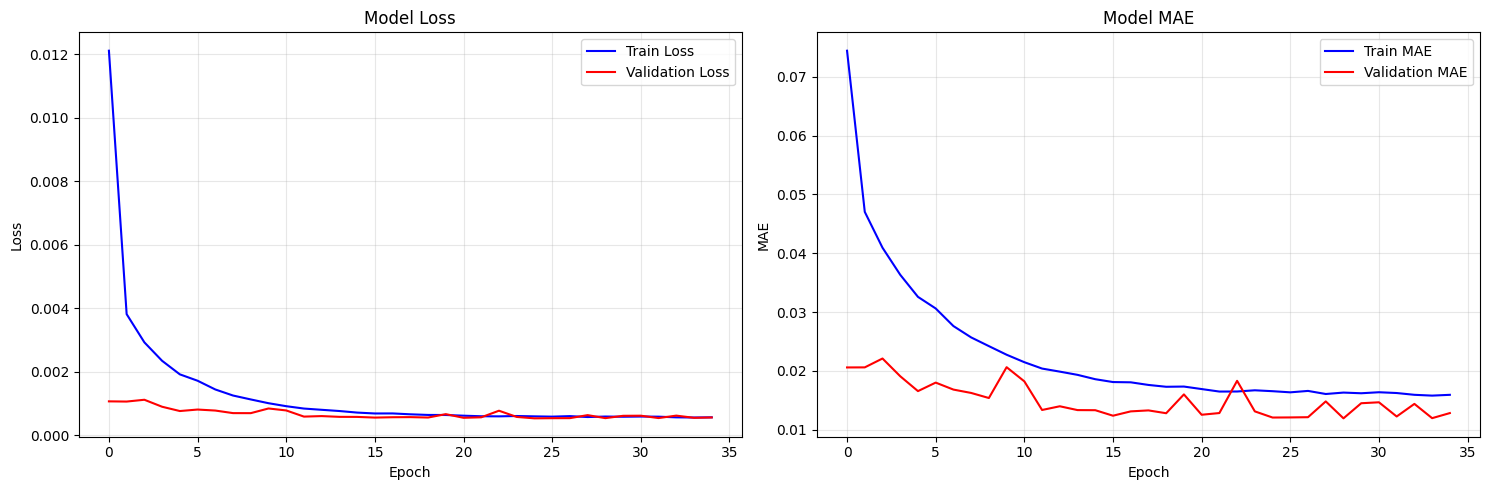

In [18]:
# Graficar historial de entrenamiento
def plot_training_history(history):
    """
    Grafica la evolución del entrenamiento
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', color='blue')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAE
    axes[1].plot(history.history['mae'], label='Train MAE', color='blue')
    axes[1].plot(history.history['val_mae'], label='Validation MAE', color='red')
    axes[1].set_title('Model MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

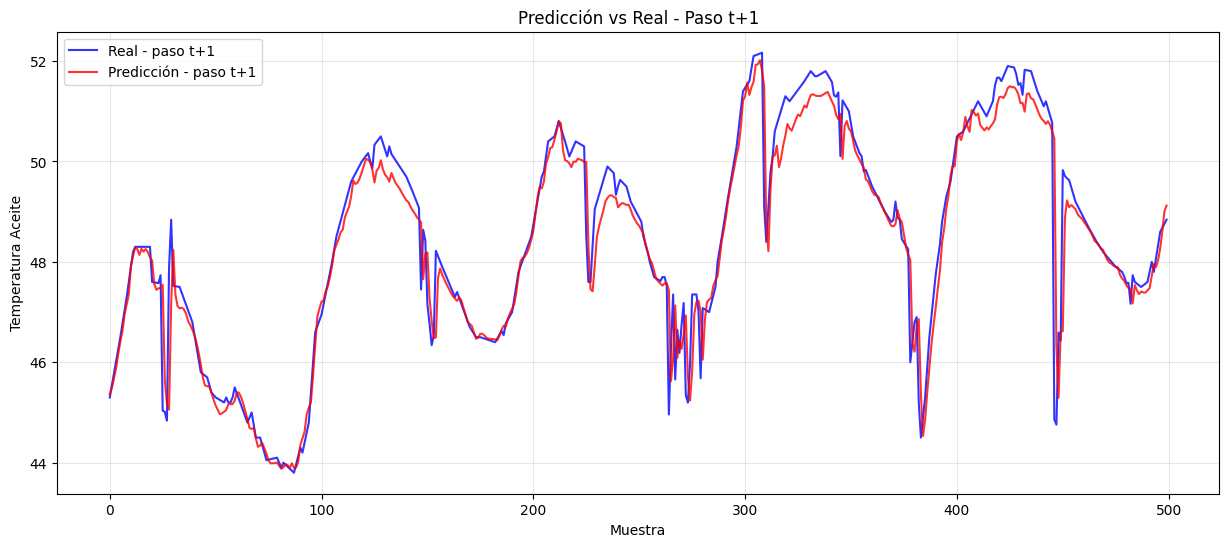

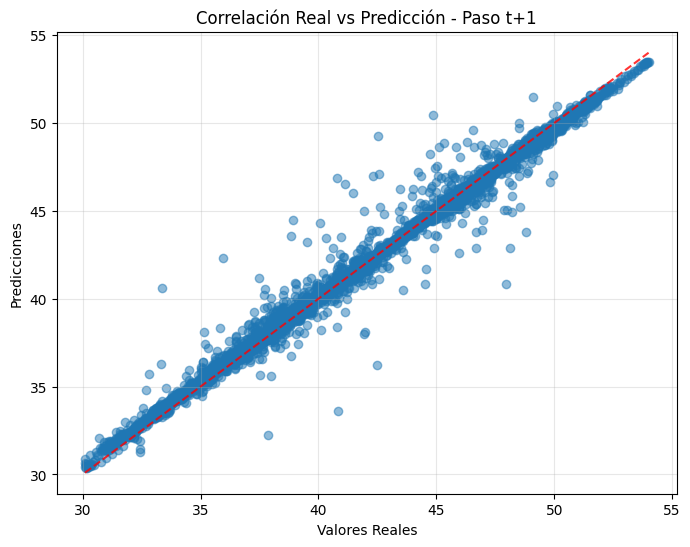

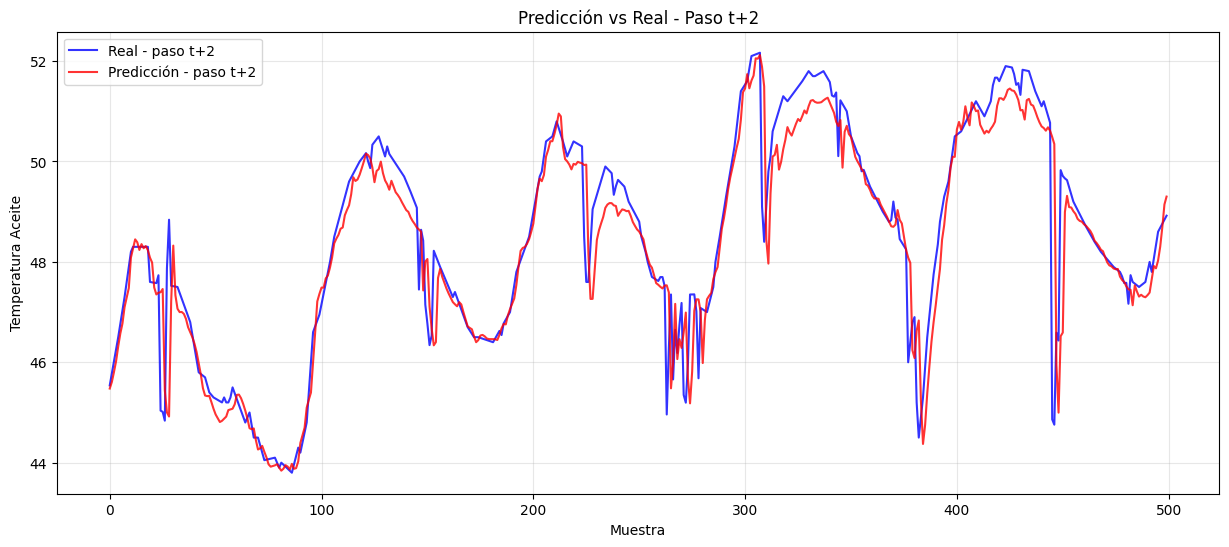

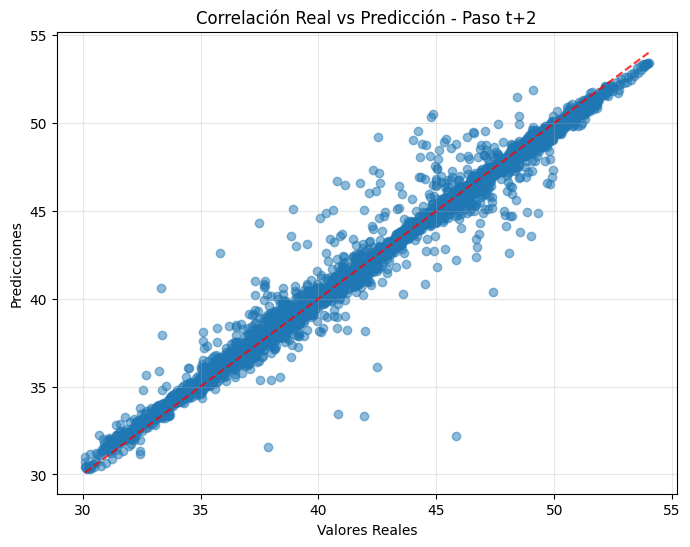

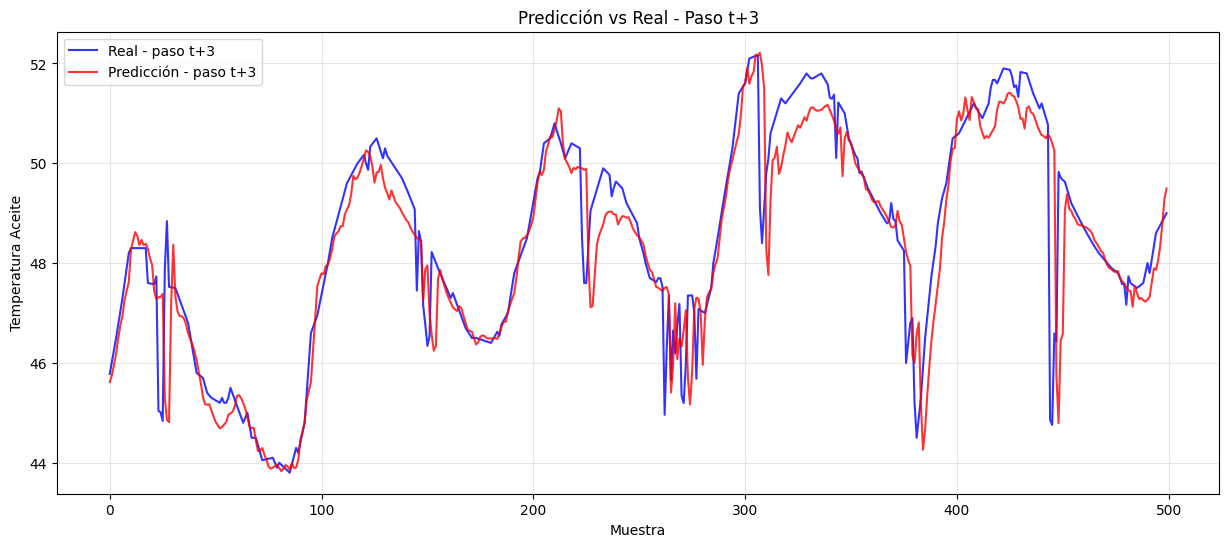

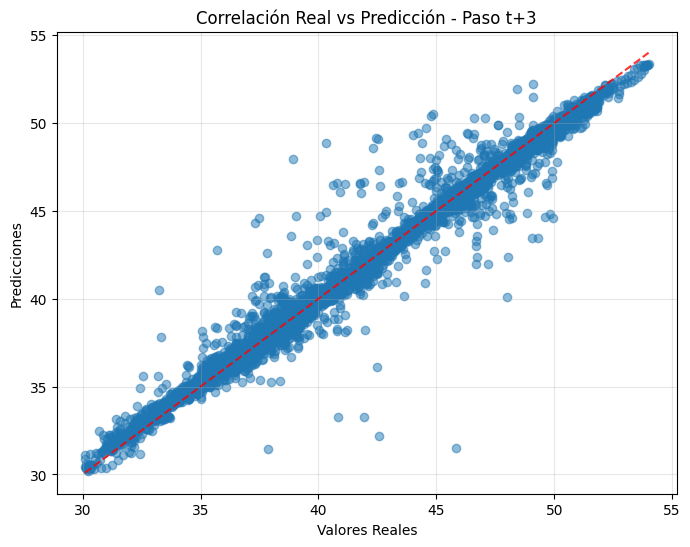

In [19]:
# Graficar predicciones vs valores reales
def plot_predictions_vs_real(pred_real, real_real, step_to_plot=0, num_samples=500):
    """
    Grafica predicciones vs valores reales para un paso específico
    """
    plt.figure(figsize=(15, 6))
    
    # Seleccionar solo una muestra de los datos para mejor visualización
    indices = np.arange(min(num_samples, len(pred_real)))
    
    plt.plot(indices, real_real[indices, step_to_plot], 
             label=f'Real - paso t+{step_to_plot+1}', color='blue', alpha=0.8)
    plt.plot(indices, pred_real[indices, step_to_plot], 
             label=f'Predicción - paso t+{step_to_plot+1}', color='red', alpha=0.8)
    
    plt.title(f'Predicción vs Real - Paso t+{step_to_plot+1}')
    plt.xlabel('Muestra')
    plt.ylabel('Temperatura Aceite')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Gráfico de dispersión
    plt.figure(figsize=(8, 6))
    plt.scatter(real_real[:, step_to_plot], pred_real[:, step_to_plot], alpha=0.5)
    
    # Línea diagonal perfecta
    min_val = min(real_real[:, step_to_plot].min(), pred_real[:, step_to_plot].min())
    max_val = max(real_real[:, step_to_plot].max(), pred_real[:, step_to_plot].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title(f'Correlación Real vs Predicción - Paso t+{step_to_plot+1}')
    plt.grid(True, alpha=0.3)
    plt.show()

# Graficar para diferentes pasos
for step in range(min(3, prediction_length)):
    plot_predictions_vs_real(pred_real, real_real, step_to_plot=step)

In [ ]:
# Función para hacer predicciones en tiempo real
def predict_future_steps(model, last_sequence, x_scaler, y_scaler, steps=5):
    """
    Predice los próximos pasos basado en la última secuencia
    """
    # Normalizar la secuencia de entrada
    last_seq_scaled = x_scaler.transform(last_sequence)
    last_seq_scaled = last_seq_scaled.reshape(1, sequence_length, len(input_features))
    
    # Hacer predicción
    prediction_scaled = model.predict(last_seq_scaled, verbose=0)
    
    # Desescalar
    prediction_real = y_scaler.inverse_transform(prediction_scaled)
    
    return prediction_real.flatten()

# Ejemplo de uso
# Tomar las últimas 20 observaciones
last_sequence = df_gold[input_features].tail(sequence_length).values
future_predictions = predict_future_steps(model, last_sequence, x_scaler, y_scaler)

print("PREDICCIONES FUTURAS:")
for i, pred in enumerate(future_predictions):
    print(f"  t+{i+1}: {pred:.2f}°C")

🔮 PREDICCIONES FUTURAS:
  t+1: 44.21°C
  t+2: 44.51°C
  t+3: 44.88°C
  t+4: 45.21°C
  t+5: 45.55°C


In [ ]:
#cuda

In [14]:
# Supón que df_cleaned es tu DataFrame procesado
input_features = ['temperatura_aceite', 'temperatura_ambiente', 'potencia_aparente', 'corriente_carga','voltaje']
target_column = 'temperatura_aceite'
sequence_length = 20
prediction_length = 5

X, Y, x_scaler, y_scaler = prepare_lstm_data(dfclean, input_features, target_column, sequence_length, prediction_length)

print(X.shape)  # → (samples, 10, 4)
print(Y.shape)  # → (samples, 3)

NameError: name 'torch' is not defined

In [237]:
# Separación por porcentaje (ej. 80% entrenamiento, 20% test)
train_size = int(len(X) * 0.8)

X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

print("Train shape:", X_train.shape, Y_train.shape)
print("Test shape:", X_test.shape, Y_test.shape)

# DataLoader para entrenamiento
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=64, shuffle=False)

Train shape: torch.Size([18456, 20, 5]) torch.Size([18456, 5])
Test shape: torch.Size([4614, 20, 5]) torch.Size([4614, 5])


In [238]:
import torch.nn as nn

class LSTMForecast(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, output_size=3, dropout=0.2):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        out, _ = self.lstm(x)              # out: (batch, seq_len, hidden)
        out = out[:, -1, :]                # Tomamos solo la salida final
        out = self.fc(out)                 # out: (batch, output_size)
        return out


In [239]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())
print(torch.cuda.current_device())
torch.cuda.get_device_name(0)

cuda
1
0


'NVIDIA GeForce RTX 2070 with Max-Q Design'

In [240]:
import torch
import torch.nn as nn
import torch.optim as optim

# Configuración
input_dim = len(input_features)  # = 4
hidden_dim = 32
num_layers = 2
dropout = 0.2
lr = 0.001

# Modelo
model = LSTMForecast(input_dim, hidden_dim, num_layers, prediction_length, dropout).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adamax(model.parameters(), lr=lr)


In [241]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Inicialización
epochs = 150
train_losses, val_losses, val_losses_real, train_losses_real = [], [], [], []
maes_real, rmses_real, r2s_real = [], [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * X_batch.size(0)

    train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # VALIDACIÓN
    model.eval()
    val_loss = 0.0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch)
            val_loss += loss_fn(pred, y_batch).item() * X_batch.size(0)
            all_preds.append(pred.cpu())
            all_targets.append(y_batch.cpu())

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)

    # Convertimos a NumPy
    preds = torch.cat(all_preds).numpy()
    targets = torch.cat(all_targets).numpy()

    # Desescalar
    preds_real = y_scaler.inverse_transform(preds)
    targets_real = y_scaler.inverse_transform(targets)

    # Loss en escala real (RMSE)
    val_loss_real = np.sqrt(mean_absolute_error(targets_real, preds_real))
    val_losses_real.append(val_loss_real)
    
    # Loss del entrenamiento en escala real
    train_loss_real = np.sqrt(mean_absolute_error(targets_real, preds_real))
    train_losses_real.append(val_loss_real)

    # Métricas globales (escala real)
    mae_r = mean_absolute_error(targets_real, preds_real)
    rmse_r = val_loss_real
    r2_r = r2_score(targets_real, preds_real)

    maes_real.append(mae_r)
    rmses_real.append(rmse_r)
    r2s_real.append(r2_r)

    # Imprimir resumen
    print(f"\nEpoch {epoch+1:>2}/{epochs} - "
          f"Train Loss: {train_loss:.4f} - Val Loss (norm): {val_loss:.4f} - "
          f"Val Loss (real RMSE): {val_loss_real:.4f}")

    # Métricas por paso futuro
    for i in range(preds.shape[1]):
        step_mae = mean_absolute_error(targets_real[:, i], preds_real[:, i])
        step_rmse = np.sqrt(mean_squared_error(targets_real[:, i], preds_real[:, i]))
        step_r2 = r2_score(targets_real[:, i], preds_real[:, i])
        print(f" Paso t+{i+1}: MAE={step_mae:.4f}, RMSE={step_rmse:.4f}, R²={step_r2:.4f}")



Epoch  1/150 - Train Loss: 0.0223 - Val Loss (norm): 0.0029 - Val Loss (real RMSE): 1.1929
 Paso t+1: MAE=1.4119, RMSE=1.8456, R²=0.7761
 Paso t+2: MAE=1.4630, RMSE=1.9100, R²=0.7601
 Paso t+3: MAE=1.4779, RMSE=1.9216, R²=0.7570
 Paso t+4: MAE=1.4082, RMSE=1.8832, R²=0.7665
 Paso t+5: MAE=1.3540, RMSE=1.7763, R²=0.7921

Epoch  2/150 - Train Loss: 0.0031 - Val Loss (norm): 0.0012 - Val Loss (real RMSE): 0.9249
 Paso t+1: MAE=0.8495, RMSE=1.1465, R²=0.9136
 Paso t+2: MAE=0.9028, RMSE=1.2218, R²=0.9018
 Paso t+3: MAE=0.9077, RMSE=1.2645, R²=0.8948
 Paso t+4: MAE=0.8019, RMSE=1.1998, R²=0.9052
 Paso t+5: MAE=0.8157, RMSE=1.2553, R²=0.8962

Epoch  3/150 - Train Loss: 0.0018 - Val Loss (norm): 0.0010 - Val Loss (real RMSE): 0.8675
 Paso t+1: MAE=0.7003, RMSE=0.9687, R²=0.9383
 Paso t+2: MAE=0.7597, RMSE=1.0532, R²=0.9270
 Paso t+3: MAE=0.7289, RMSE=1.0758, R²=0.9238
 Paso t+4: MAE=0.7544, RMSE=1.1204, R²=0.9173
 Paso t+5: MAE=0.8192, RMSE=1.2191, R²=0.9021

Epoch  4/150 - Train Loss: 0.0015

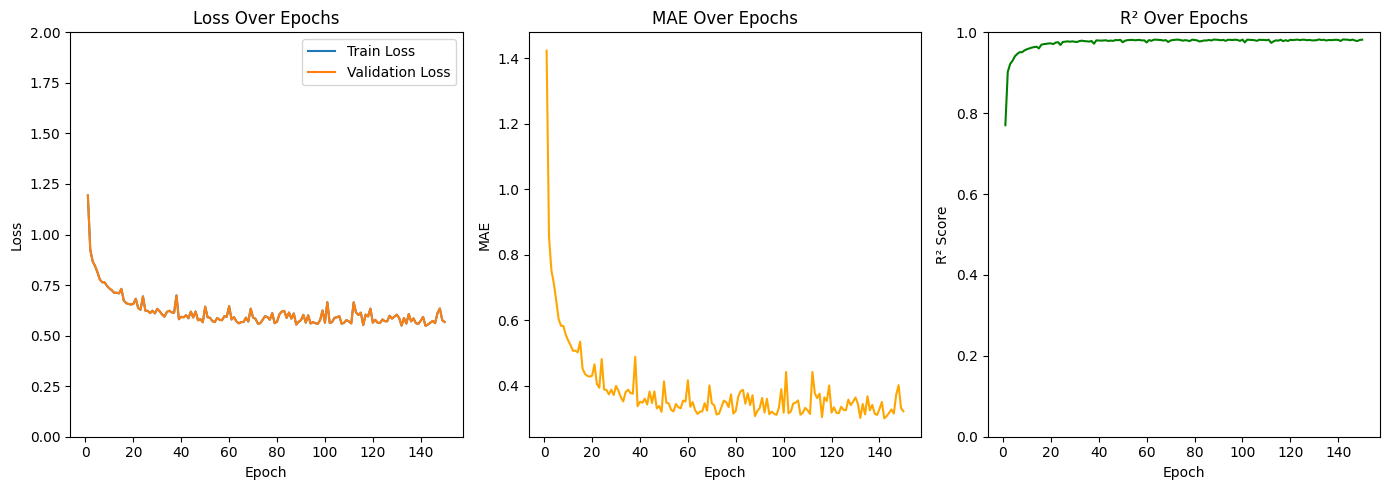

In [242]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 5))

# Pérdida
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses_real, label="Train Loss")
plt.plot(epochs_range, val_losses_real, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
ax = plt.gca()
ax.set_ylim([0, 2])

# MAE
plt.subplot(1, 3, 2)
plt.plot(epochs_range, maes_real, label="MAE", color='orange')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE Over Epochs")

# R2
plt.subplot(1, 3, 3)
plt.plot(epochs_range, r2s_real, label="R²", color='green')
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("R² Over Epochs")
ax3 = plt.gca()
ax3.set_ylim([0, 1])


plt.tight_layout()
plt.show()


In [243]:
model.eval()
predictions = []
real = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(X_batch)

        predictions.append(preds.cpu().numpy())  # Predicción
        real.append(y_batch.cpu().numpy())       # Valor real

predictions = np.concatenate(predictions, axis=0)
real = np.concatenate(real, axis=0)

print(predictions.shape)  # (2306, 3)
print(real.shape)         # (2306, 3)

(4614, 5)
(4614, 5)


In [244]:
#convertir array a DataFrame
import pandas as pd
pred_scaled = y_scaler.inverse_transform(predictions)
pred_df = pd.DataFrame(pred_scaled, columns=[f"Pred_{i+1}" for i in range(predictions.shape[1])])
pred_df

,Pred_1,Pred_2,Pred_3,Pred_4,Pred_5
0,38.459915,38.521610,38.646976,38.749252,38.812031
1,38.460121,38.534302,38.672714,38.797535,38.880501
2,38.475433,38.561203,38.710449,38.850533,38.948521
3,38.529350,38.626354,38.784775,38.932144,39.039330
4,38.560078,38.655468,38.812695,38.954811,39.064922
...,...,...,...,...,...
4609,46.476517,46.409996,46.388046,46.316547,46.233494
4610,46.522179,46.452740,46.432880,46.353535,46.269390
4611,46.351048,46.229977,46.167690,46.053356,45.937908
4612,46.467819,46.354286,46.288074,46.159863,46.032108


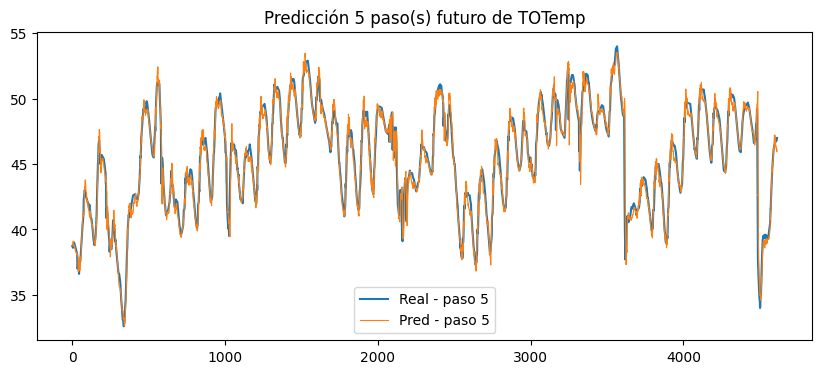

In [249]:
# Suponiendo que usaste y_scaler con [[TOTemp]] como output
pred_original = y_scaler.inverse_transform(predictions)
real_original = y_scaler.inverse_transform(real)

# Graficar 1er paso de predicción
import matplotlib.pyplot as plt

paso = 4

plt.figure(figsize=(10, 4))
plt.plot(real_original[:, paso], label=f'Real - paso {paso + 1}')
plt.plot(pred_original[:, paso], label=f'Pred - paso {paso + 1}', linestyle='-', linewidth=0.8)
plt.legend()
plt.title(f'Predicción {paso+1} paso(s) futuro de TOTemp')
plt.show()

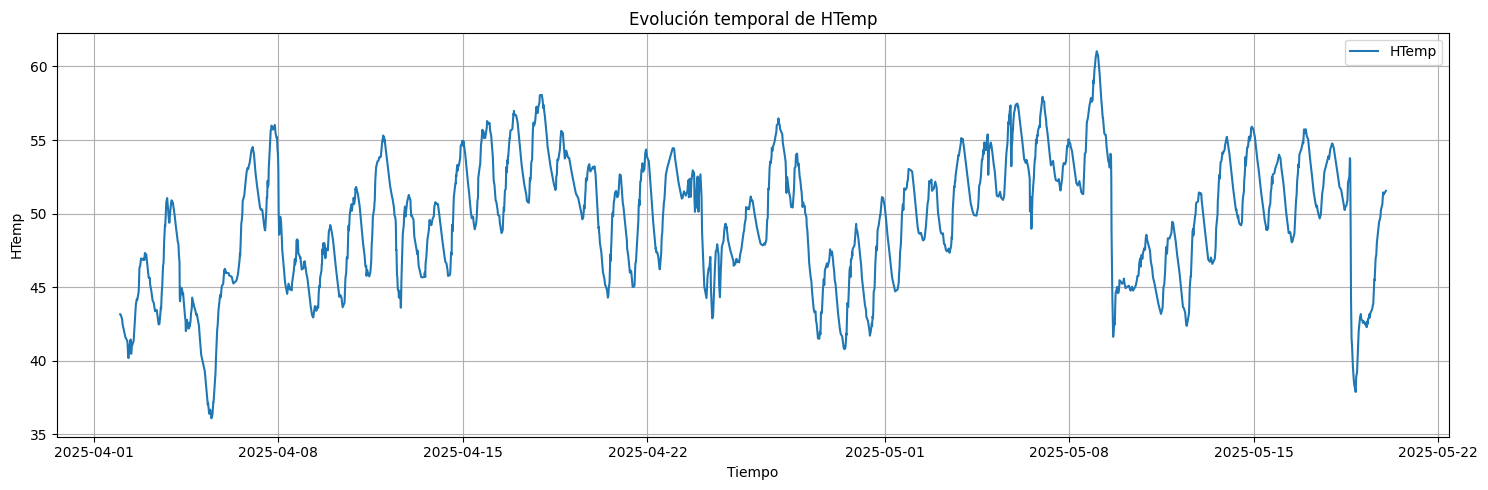

In [246]:
timeplot(dfclean["04-02-25":"05-20-25"], "HTemp")